# Airbnb - Machine Learning Practice
***
`jupyter nbextension enable --py gmaps`
<br/>
`pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip`

Chicago Listings & Reviews - 11/2019
<br/>
http://insideairbnb.com/get-the-data.html

In [1]:
%matplotlib inline

import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time


# profile = ProfileReport(air_df, title='Pandas Profiling Report', html={'style':{'full_width':True}})
# profile

## Initial General Cleaning
There were some columns and fields with values of `none` rather than `NaN`, so they will be auto-filled with null values. 

In [23]:
air_df = pd.read_csv('data/listings.csv', low_memory = False, na_values = 'none')
air_df = air_df.fillna(np.nan)

print(air_df.info())

pd.set_option('display.max_columns', len(air_df.columns))
air_df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8533 entries, 0 to 8532
Columns: 106 entries, id to reviews_per_month
dtypes: float64(22), int64(23), object(61)
memory usage: 6.9+ MB
None


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2384,https://www.airbnb.com/rooms/2384,20191121092422,2019-11-21,"Walk to UChicago, 10 min train to McCormick Place",Visiting The University of Chicago or attendin...,"The private bedroom has a queen size bed, beds...",Visiting The University of Chicago or attendin...,NaN,My apartment is one block from beautiful Jacks...,The basement laundry room hours are 8:00am to ...,UNIVERSITY OF CHICAGO: Visiting academics and ...,You will have access to the entire apartment -...,I will greet you when you arrive and show you ...,1. Your booking is for ONE (1) person only - t...,NaN,NaN,https://a0.muscache.com/im/pictures/acf6b3c0-4...,NaN,2613,https://www.airbnb.com/users/show/2613,Rebecca,2008-08-29,"Chicago, Illinois, United States",My 2 bdrm apartment is a 2nd floor walk-up in ...,within an hour,100%,NaN,t,https://a0.muscache.com/im/pictures/user/8bb47...,https://a0.muscache.com/im/pictures/user/8bb47...,Hyde Park,1,1,"['email', 'phone', 'reviews', 'manual_offline'...",t,t,"Chicago, IL, United States",Hyde Park,Hyde Park,NaN,Chicago,IL,60637,Chicago,"Chicago, IL",US,United States,41.78886,-87.58671,t,Condominium,Private room,1,1.0,1.0,1.0,Real Bed,"{TV,Wifi,Kitchen,""Free street parking"",Heating...",NaN,$50.00,$350.00,NaN,$0.00,$0.00,1,$0.00,2,30,2,2,1125,1125,2.0,1125.0,2 weeks ago,t,21,44,74,349,2019-11-21,176,39,2015-01-09,2019-11-13,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t,NaN,"{""Illinois State"","" Cook County"","" IL"","" CHICA...",f,f,strict_14_with_grace_period,f,f,1,0,1,0,2.97
1,4505,https://www.airbnb.com/rooms/4505,20191121092422,2019-11-21,One Great Apartment. 384 Great Reviews. 1 Bad ...,"We took the winter off, made things nicer arou...","We travel a lot, we know what people need. We...","We took the winter off, made things nicer arou...",NaN,NaN,NaN,The CTA train station is 30 yards (27 meters) ...,We also have a huge yard. Use it (weather perm...,NaN,Don't sit around all day watching T.V. Don't h...,NaN,NaN,https://a0.muscache.com/im/pictures/15019798/7...,NaN,5775,https://www.airbnb.com/users/show/5775,Craig & Kathleen,2008-12-29,"Chicago, Illinois, United States",Incredibly creative(Kathleen) and stunningly a...,within a few hours,100%,NaN,t,https://a0.muscache.com/im/users/5775/profile_...,https://a0.muscache.com

In [25]:
temp = air_df[['price', 
               'weekly_price', 
               'monthly_price', 
               'security_deposit', 
               'cleaning_fee', 
               'extra_people'
              ]].copy()

temp.dtypes

price               object
weekly_price        object
monthly_price       object
security_deposit    object
cleaning_fee        object
extra_people        object
dtype: object

Columns indicating currency were imported as strings and will need to be converted to float. `$` and `,` to be removed.

In [26]:
temp = temp.columns.tolist()

for col in temp:
    air_df[col] = air_df[col].replace({'\$' : '', ',' : ''}, regex=True).astype(float)
    air_df[col].fillna(0,inplace=True)
    
air_df['price'].dtypes

dtype('float64')

# Preemptively Comparing Price, Space, and Location
</br>
The intial assumption was that location affects price the most. Price and location coordinates were plotted without additional cleaning to see the current state of the data. 

Top Daily Rental Prices Descending: 
6793    10000.0
1457    10000.0
7037    10000.0
7038    10000.0
7080    10000.0
7081    10000.0
7082    10000.0
6794    10000.0
8252    10000.0
8253    10000.0
8254    10000.0
3730    10000.0
2417     9999.0
7087     8000.0
3738     6200.0
Name: price, dtype: float64



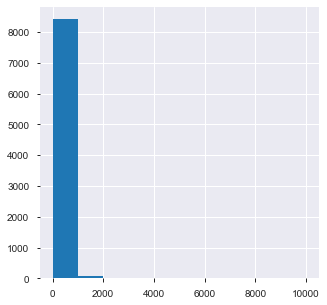

In [27]:
temp = air_df.copy()

print(f"Top Daily Rental Prices Descending: \n{temp['price'].sort_values(ascending=False).head(15)}\n")
      
temp['price'].hist(figsize=(5,5));

It's very apparent there are outliers skewing the data range

# of listings per neighborhood over $1,000: 
River West                 9
Near North Side            9
Logan Square               8
South Loop/Printers Row    7
Lakeview                   7
Wicker Park                6
Old Town                   5
Streeterville              3
River North                3
Uptown                     2
Name: neighbourhood, dtype: int64

There are 76 neighborhood listings over $1,000. 0.9% of total listings.


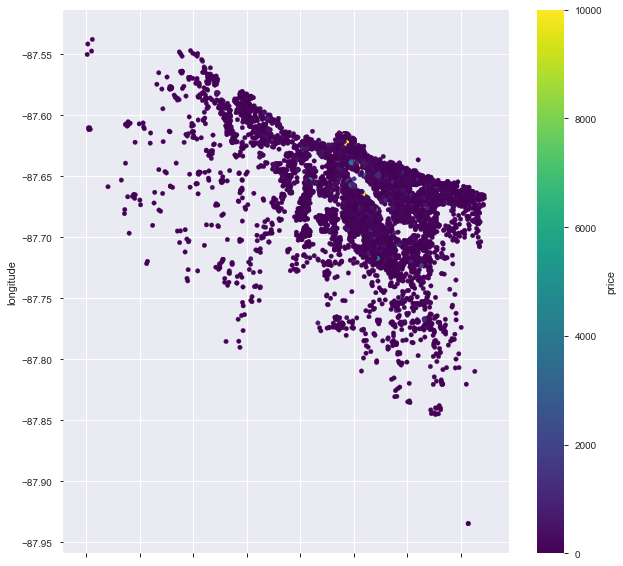

In [28]:
temp = temp[temp.price > 1000]
print(f"# of listings per neighborhood over $1,000: \n{temp['neighbourhood'].value_counts()[:10]}")

x = temp['neighbourhood'].value_counts().sum()
print(f'\nThere are {x:,} neighborhood listings over $1,000. {x/len(air_df):.1%} of total listings.')
      
air_df.plot.scatter(x='latitude', y='longitude', c='price', colormap='viridis', figsize=(10,10) ); 

The outliers create a chart that show minimal price variation 

In [29]:
air_df = air_df[air_df['price'] <= 1000]

print(air_df.info())
air_df.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8457 entries, 0 to 8532
Columns: 106 entries, id to reviews_per_month
dtypes: float64(28), int64(23), object(55)
memory usage: 6.9+ MB
None


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2384,https://www.airbnb.com/rooms/2384,20191121092422,2019-11-21,"Walk to UChicago, 10 min train to McCormick Place",Visiting The University of Chicago or attendin...,"The private bedroom has a queen size bed, beds...",Visiting The University of Chicago or attendin...,NaN,My apartment is one block from beautiful Jacks...,The basement laundry room hours are 8:00am to ...,UNIVERSITY OF CHICAGO: Visiting academics and ...,You will have access to the entire apartment -...,I will greet you when you arrive and show you ...,1. Your booking is for ONE (1) person only - t...,NaN,NaN,https://a0.muscache.com/im/pictures/acf6b3c0-4...,NaN,2613,https://www.airbnb.com/users/show/2613,Rebecca,2008-08-29,"Chicago, Illinois, United States",My 2 bdrm apartment is a 2nd floor walk-up in ...,within an hour,100%,NaN,t,https://a0.muscache.com/im/pictures/user/8bb47...,https://a0.muscache.com/im/pictures/user/8bb47...,Hyde Park,1,1,"['email', 'phone', 'reviews', 'manual_offline'...",t,t,"Chicago, IL, United States",Hyde Park,Hyde Park,NaN,Chicago,IL,60637,Chicago,"Chicago, IL",US,United States,41.78886,-87.58671,t,Condominium,Private room,1,1.0,1.0,1.0,Real Bed,"{TV,Wifi,Kitchen,""Free street parking"",Heating...",NaN,50.0,350.0,0.0,0.0,0.0,1,0.0,2,30,2,2,1125,1125,2.0,1125.0,2 weeks ago,t,21,44,74,349,2019-11-21,176,39,2015-01-09,2019-11-13,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t,NaN,"{""Illinois State"","" Cook County"","" IL"","" CHICA...",f,f,strict_14_with_grace_period,f,f,1,0,1,0,2.97
1,4505,https://www.airbnb.com/rooms/4505,20191121092422,2019-11-21,One Great Apartment. 384 Great Reviews. 1 Bad ...,"We took the winter off, made things nicer arou...","We travel a lot, we know what people need. We...","We took the winter off, made things nicer arou...",NaN,NaN,NaN,The CTA train station is 30 yards (27 meters) ...,We also have a huge yard. Use it (weather perm...,NaN,Don't sit around all day watching T.V. Don't h...,NaN,NaN,https://a0.muscache.com/im/pictures/15019798/7...,NaN,5775,https://www.airbnb.com/users/show/5775,Craig & Kathleen,2008-12-29,"Chicago, Illinois, United States",Incredibly creative(Kathleen) and stunningly a...,within a few hours,100%,NaN,t,https://a0.muscache.com/im/users/5775/profile_...,https://a0.muscache.com/im/users/

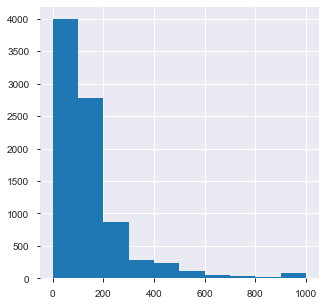

In [30]:
air_df['price'].hist(figsize=(5,5));

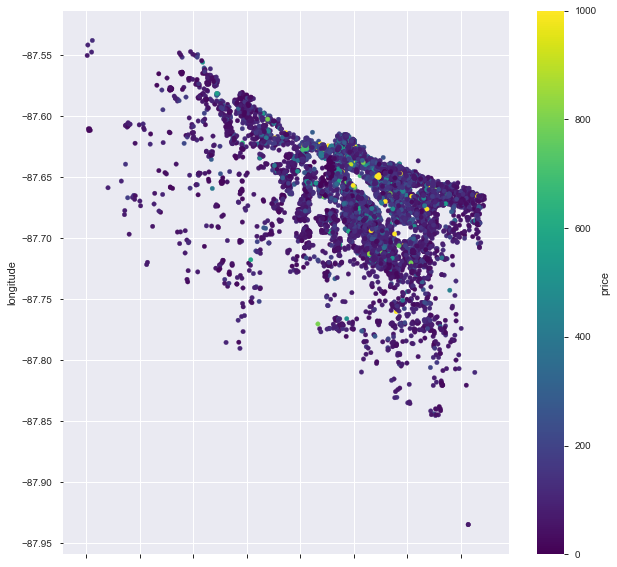

In [31]:
air_df.plot.scatter(x='latitude', y='longitude', c='price', colormap='viridis', figsize=(10,10) ); 

Majority of listings are under the $200 a night threshold and brought in significant color back into the scatter plot. 

#### Reviewing & Dropping Null Values and Columns

In [32]:
temp = air_df.isna().sum().sort_values(ascending = False)
temp = pd.DataFrame(temp).reset_index()

temp.head(10)

,index,0
0,xl_picture_url,8457
1,neighbourhood_group_cleansed,8457
2,host_acceptance_rate,8457
3,medium_url,8457
4,thumbnail_url,8457
5,experiences_offered,8457
6,square_feet,8402
7,notes,3609
8,access,2908
9,host_about,2633


In [33]:
temp = temp[temp[0] > len(air_df)/2]
temp = temp['index'].tolist()

temp

['xl_picture_url',
 'neighbourhood_group_cleansed',
 'host_acceptance_rate',
 'medium_url',
 'thumbnail_url',
 'experiences_offered',
 'square_feet']

Dropping the columns where more than half the values are null

In [34]:
air_df.drop(temp, axis=1, inplace=True)

air_df.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,neighborhood_overview,notes,transit,access,interaction,house_rules,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2384,https://www.airbnb.com/rooms/2384,20191121092422,2019-11-21,"Walk to UChicago, 10 min train to McCormick Place",Visiting The University of Chicago or attendin...,"The private bedroom has a queen size bed, beds...",Visiting The University of Chicago or attendin...,My apartment is one block from beautiful Jacks...,The basement laundry room hours are 8:00am to ...,UNIVERSITY OF CHICAGO: Visiting academics and ...,You will have access to the entire apartment -...,I will greet you when you arrive and show you ...,1. Your booking is for ONE (1) person only - t...,https://a0.muscache.com/im/pictures/acf6b3c0-4...,2613,https://www.airbnb.com/users/show/2613,Rebecca,2008-08-29,"Chicago, Illinois, United States",My 2 bdrm apartment is a 2nd floor walk-up in ...,within an hour,100%,t,https://a0.muscache.com/im/pictures/user/8bb47...,https://a0.muscache.com/im/pictures/user/8bb47...,Hyde Park,1,1,"['email', 'phone', 'reviews', 'manual_offline'...",t,t,"Chicago, IL, United States",Hyde Park,Hyde Park,Chicago,IL,60637,Chicago,"Chicago, IL",US,United States,41.78886,-87.58671,t,Condominium,Private room,1,1.0,1.0,1.0,Real Bed,"{TV,Wifi,Kitchen,""Free street parking"",Heating...",50.0,350.0,0.0,0.0,0.0,1,0.0,2,30,2,2,1125,1125,2.0,1125.0,2 weeks ago,t,21,44,74,349,2019-11-21,176,39,2015-01-09,2019-11-13,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t,NaN,"{""Illinois State"","" Cook County"","" IL"","" CHICA...",f,f,strict_14_with_grace_period,f,f,1,0,1,0,2.97
1,4505,https://www.airbnb.com/rooms/4505,20191121092422,2019-11-21,One Great Apartment. 384 Great Reviews. 1 Bad ...,"We took the winter off, made things nicer arou...","We travel a lot, we know what people need. We...","We took the winter off, made things nicer arou...",NaN,NaN,The CTA train station is 30 yards (27 meters) ...,We also have a huge yard. Use it (weather perm...,NaN,Don't sit around all day watching T.V. Don't h...,https://a0.muscache.com/im/pictures/15019798/7...,5775,https://www.airbnb.com/users/show/5775,Craig & Kathleen,2008-12-29,"Chicago, Illinois, United States",Incredibly creative(Kathleen) and stunningly a...,within a few hours,100%,t,https://a0.muscache.com/im/users/5775/profile_...,https://a0.muscache.com/im/users/5775/profile_...,Little Village,1,1,"['email', 'phone', 'reviews', 'kba']",t,t,"Chicago, IL, United States",Little Village,South Lawndale,Chicago,IL,60608,Chicago,"Chicag

Converting Strings in the T/F Response Columns

In [35]:
air_df.replace({'f': 0, 't': 1}, inplace=True)

air_df['instant_bookable'].head(2)

0    0
1    1
Name: instant_bookable, dtype: int64

#### Separating Column Names by Type
<br/>


In [55]:
temp = air_df.dtypes.to_dict()
temp

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name']

In [53]:
for x in list(temp)[0:3]:
    print ("key {}, value {} ".format(x,  temp[x]))

id
listing_url
scrape_id


In [57]:
dict(list(temp.items())[0: 5]) 

{'id': dtype('int64'),
 'listing_url': dtype('O'),
 'scrape_id': dtype('int64'),
 'last_scraped': dtype('O'),
 'name': dtype('O')}

In [37]:
temp = air_df.dtypes.apply(lambda x: x.name).to_dict()


# converting the dictionary to a list so it can be sliced
# converting back to dictionary
dict(list(temp.items())[:5])

{'id': 'int64',
 'listing_url': 'object',
 'scrape_id': 'int64',
 'last_scraped': 'object',
 'name': 'object'}

In [38]:
str_col = []

for key, val in temp.items():
    if val == 'object': 
        str_col.append(key)
    else:
        pass

del temp

print(f'{len(str_col)} string columns')
str_col

45 string columns


['listing_url',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'picture_url',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_verifications',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'property_type',
 'room_type',
 'bed_type',
 'amenities',
 'calendar_updated',
 'calendar_last_scraped',
 'first_review',
 'last_review',
 'license',
 'jurisdiction_names',
 'cancellation_policy']

In [39]:
temp = ['neighbourhood', 
        'neighbourhood_cleansed', 
        'property_type', 
        'room_type', 
        'bed_type', 
        'amenities'
       ]

# sets can be subracted from set. converting the net result back into a list
temp = list(set(str_col) - set(temp))

print(f'{len(temp)} string columns')
temp

39 string columns


['description',
 'notes',
 'cancellation_policy',
 'state',
 'street',
 'transit',
 'license',
 'neighborhood_overview',
 'first_review',
 'picture_url',
 'host_name',
 'zipcode',
 'host_response_rate',
 'space',
 'host_thumbnail_url',
 'last_scraped',
 'host_about',
 'market',
 'jurisdiction_names',
 'host_verifications',
 'smart_location',
 'last_review',
 'listing_url',
 'city',
 'calendar_last_scraped',
 'name',
 'calendar_updated',
 'host_picture_url',
 'host_neighbourhood',
 'interaction',
 'host_response_time',
 'host_location',
 'country',
 'house_rules',
 'access',
 'host_url',
 'host_since',
 'summary',
 'country_code']

In [40]:
air_df.drop(temp, axis=1, inplace=True)
del str_col, temp

air_df.head(2)

,id,scrape_id,host_id,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2384,20190922191701,2613,1,1,1,1,1,Hyde Park,Hyde Park,41.78886,-87.58671,1,Condominium,Private room,1,1.0,1.0,1.0,Real Bed,"{TV,Wifi,Kitchen,Breakfast,""Free street parkin...",50.0,0.0,20.0,1,0.0,2,91,2,2,91,91,2.0,91.0,1,2,28,55,330,170,38,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,1,0,0,0,1,0,1,0,2.97
1,4505,20190922191701,5775,1,1,1,1,1,Little Village,South Lawndale,41.85495,-87.69696,1,Apartment,Entire home/apt,7,1.0,3.0,4.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",117.0,0.0,35.0,2,25.0,2,60,2,2,60,60,2.0,60.0,1,19,43,73,348,383,22,96.0,10.0,10.0,10.0,10.0,10.0,10.0,1,1,0,0,0,1,1,0,0,2.98


#### Investigating Remaining String Columns Further

In [43]:
# https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Chicago
# neighbourhood_cleaned seems to be community
# neighbourhood offers more variability and will be kept

air_df[['neighbourhood', 'neighbourhood_cleansed']].head(10)

,neighbourhood,neighbourhood_cleansed
0,Hyde Park,Hyde Park
1,Little Village,South Lawndale
2,Ukrainian Village,West Town
3,Old Town,Lincoln Park
4,Old Town,Lincoln Park
5,Lincoln Park,Lincoln Park
6,West Town/Noble Square,West Town
7,Old Town,Lincoln Park
8,Bucktown,Logan Square
9,Uptown,Uptown


In [42]:
temp = ['property_type', 
        'room_type', 
        'bed_type'
       ]

for x in temp:
    print(f'\n{x.upper()}:')
    print(air_df[x].value_counts())
    
del temp


PROPERTY_TYPE:
Apartment             5101
Condominium           1317
House                 1173
Loft                   231
Townhouse              230
Guest suite            184
Serviced apartment     159
Bungalow                73
Boutique hotel          71
Guesthouse              53
Bed and breakfast       19
Hostel                  16
Other                   10
Cottage                  7
Boat                     6
Hotel                    5
Tiny house               5
Aparthotel               4
Castle                   3
Resort                   3
Camper/RV                2
Barn                     2
Cave                     1
Farm stay                1
Villa                    1
Campsite                 1
Hut                      1
Name: property_type, dtype: int64

ROOM_TYPE:
Entire home/apt    5859
Private room       2480
Shared room         195
Hotel room          145
Name: room_type, dtype: int64

BED_TYPE:
Real Bed         8581
Airbed             34
Futon              32
Pull-o

In [44]:
air_df.property_type.replace({
    'Townhouse': 'House',
    'Serviced apartment': 'Apartment', 
    }, inplace=True)

temp = ['Apartment', 
        'Condominium', 
        'House'
       ]

air_df['property_type'] = air_df['property_type'].apply(lambda x: x if x in temp else 'Other')
air_df['property_type'].value_counts()

Apartment      5260
House          1403
Condominium    1317
Other           699
Name: property_type, dtype: int64

In [45]:
temp = ['id', 
        'scrape_id', 
        'host_id', 
        'neighbourhood_cleansed', 
        'bed_type'
       ]

air_df.drop(temp, axis=1, inplace=True)
del temp

air_df.head(2)

,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1,1,1,1,1,Hyde Park,41.78886,-87.58671,1,Condominium,Private room,1,1.0,1.0,1.0,"{TV,Wifi,Kitchen,Breakfast,""Free street parkin...",50.0,0.0,20.0,1,0.0,2,91,2,2,91,91,2.0,91.0,1,2,28,55,330,170,38,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,1,0,0,0,1,0,1,0,2.97
1,1,1,1,1,1,Little Village,41.85495,-87.69696,1,Apartment,Entire home/apt,7,1.0,3.0,4.0,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",117.0,0.0,35.0,2,25.0,2,60,2,2,60,60,2.0,60.0,1,19,43,73,348,383,22,96.0,10.0,10.0,10.0,10.0,10.0,10.0,1,1,0,0,0,1,1,0,0,2.98


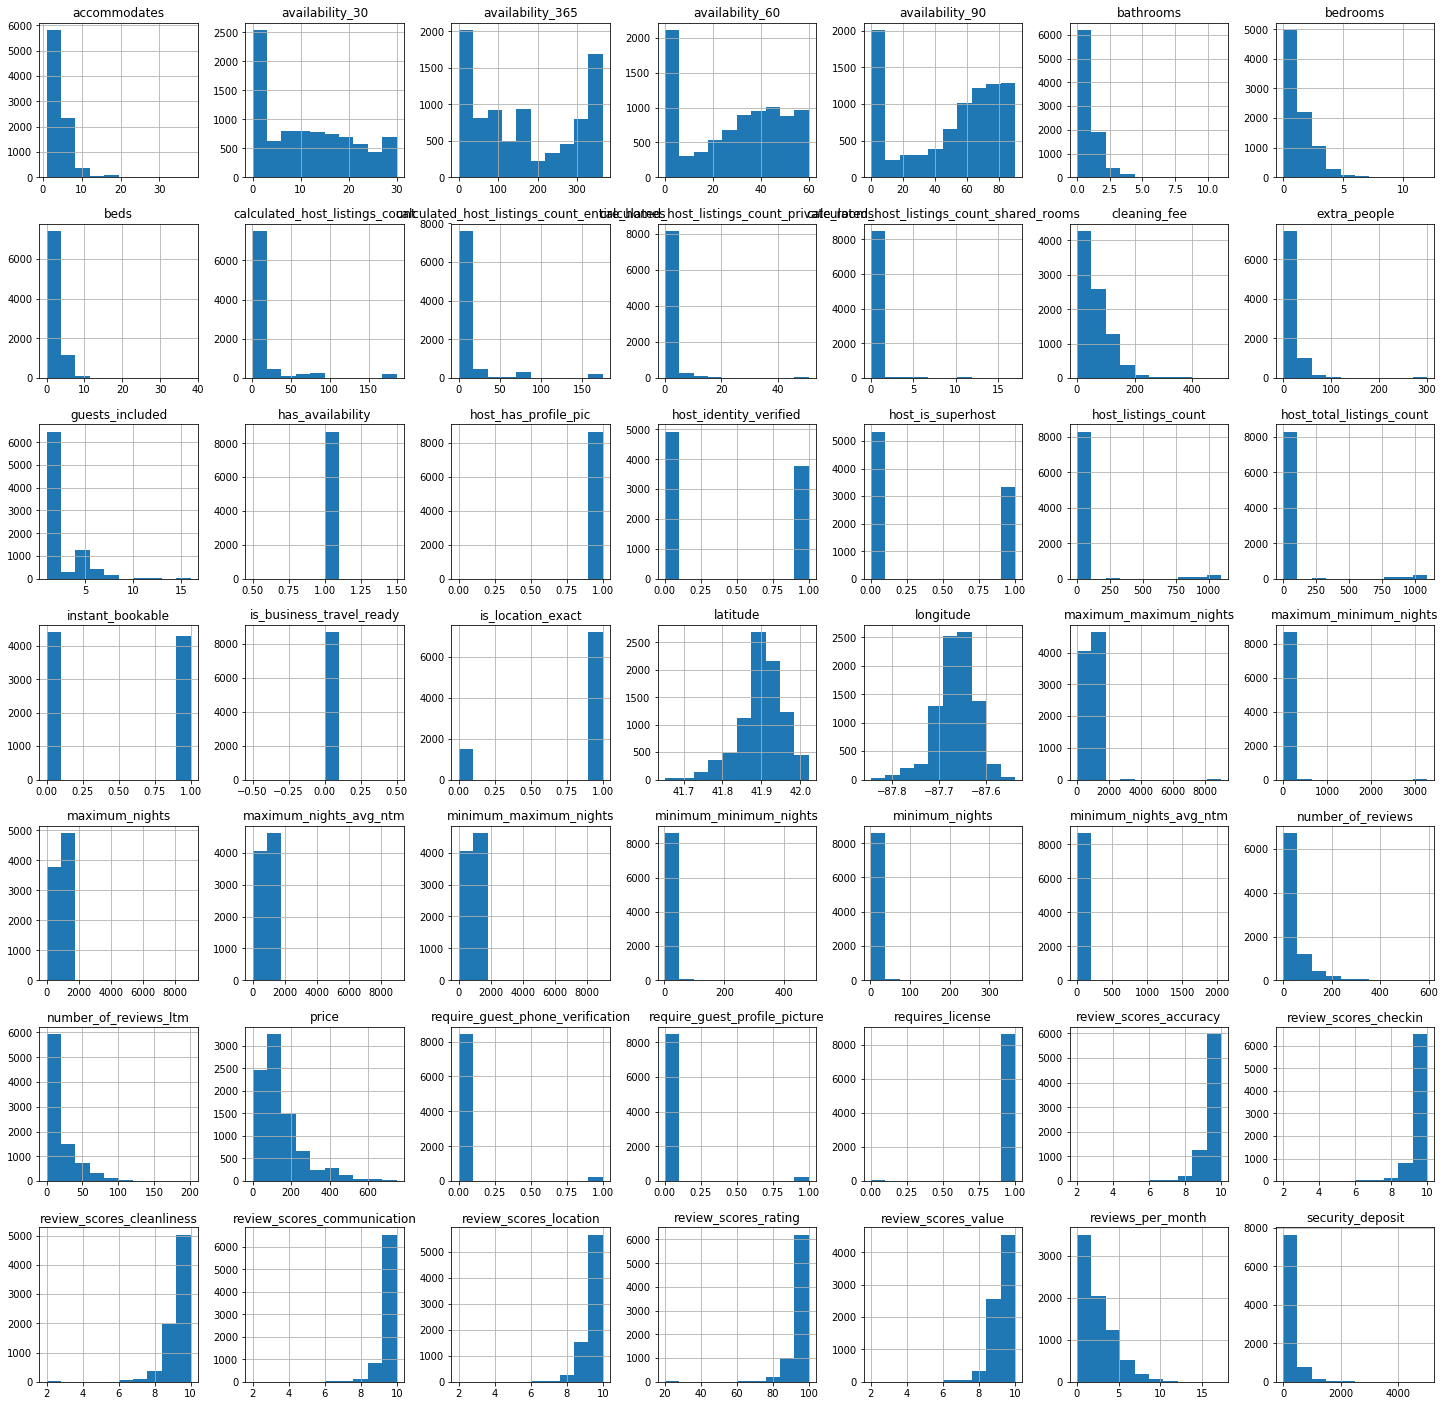

In [46]:
air_df.hist(figsize=(25,25));

In [47]:
# storing lat/long coordinates in case decide to use them later

lat_lng = air_df[['latitude','longitude']].copy()
lat_lng.head(2)

,latitude,longitude
0,41.78886,-87.58671
1,41.85495,-87.69696


In [48]:
# minimum_nights
# minimum_minimum_nights
# maximum_minimum_nights

# maximum_nights
# minimum_maximum_nights
# maximum_maximum_nights

# average nights
# minimum_nights_avg_ntm
# maximum_nights_avg_ntm

print(f' Min. diffs.: {sum((air_df.minimum_nights == air_df.minimum_minimum_nights) == False)}')
print(f' Max. diffs.: {sum((air_df.maximum_nights == air_df.maximum_maximum_nights) == False)}')

 Min. diffs.: 756
 Max. diffs.: 309


In [49]:
# 'host_total_listings_count', 
# 'calculated_host_listings_count', 
# 'calculated_host_listings_count_entire_homes', 
# 'calculated_host_listings_count_private_rooms', 
# 'calculated_host_listings_count_shared_rooms'

print(f'Tot.: {sum((air_df.host_listings_count == air_df.host_total_listings_count) == False)}')
# print(f'Calc.: {sum((air_df.host_listings_count == air_df.calculated_host_listings_count) == False)}')
# print(f'Calc. Homes: {sum((air_df.host_listings_count == air_df.calculated_host_listings_count_entire_homes) == False)}')
# print(f'Calc. Priv.: {sum((air_df.host_listings_count == air_df.calculated_host_listings_count_private_rooms) == False)}')
# print(f'Calc. Shared: {sum((air_df.host_listings_count == air_df.calculated_host_listings_count_shared_rooms) == False)}')

Tot.: 0


Both the `host_listings_count` and `host_total_listings_count` have the same values. One will be dropped

In [25]:
temp = ['host_total_listings_count', 
        'host_total_listings_count', 
        'calculated_host_listings_count', 
        'calculated_host_listings_count_entire_homes', 
        'calculated_host_listings_count_private_rooms', 
        'calculated_host_listings_count_shared_rooms', 
        'minimum_minimum_nights', 
        'maximum_minimum_nights', 
        'minimum_maximum_nights', 
        'maximum_maximum_nights', 
        'minimum_nights_avg_ntm', 
        'maximum_nights_avg_ntm', 
        'is_location_exact', 
        'has_availability', 
        'host_has_profile_pic', 
        'is_business_travel_ready', 
        'require_guest_phone_verifica
        tion', 
        'require_guest_profile_picture', 
        'requires_license'
       ]

#         'availability_30', 
#         'availability_60', 
#         'availability_90']

air_df.drop(temp, axis=1, inplace=True)
del temp

air_df.head(2)

,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month
0,1,1,1,Hyde Park,41.78886,-87.58671,Condominium,Private room,1,1.0,1.0,1.0,"{TV,Wifi,Kitchen,Breakfast,""Free street parkin...",50.0,0.0,20.0,1,0.0,2,91,330,170,38,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,2.97
1,1,1,1,Little Village,41.85495,-87.69696,Apartment,Entire home/apt,7,1.0,3.0,4.0,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",117.0,0.0,35.0,2,25.0,2,60,348,383,22,96.0,10.0,10.0,10.0,10.0,10.0,10.0,1,2.98


['host_is_superhost',
 'host_listings_count',
 'host_identity_verified',
 'neighbourhood',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'amenities',
 'price',
 'security_deposit',
 'cleaning_fee',
 'guests_included',
 'extra_people',
 'minimum_nights',
 'maximum_nights',
 'availability_365',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'instant_bookable',
 'reviews_per_month']


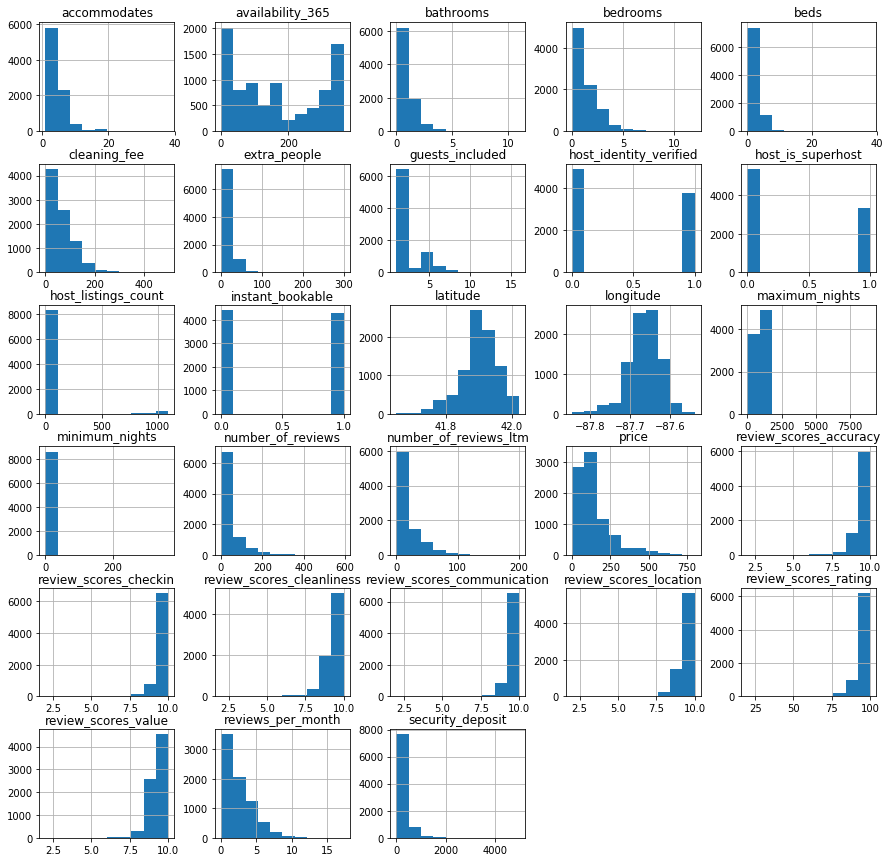

In [26]:
from pprint import pprint

test = air_df.columns.tolist()
pprint(test)

del pprint 

air_df.hist(figsize=(15,15));

In [27]:
for x in air_df:
    if air_df[x].isna().sum() > 0:
        print(f'{x}: {air_df[x].isna().sum()}')

bathrooms: 4
bedrooms: 3
beds: 1
review_scores_rating: 1138
review_scores_accuracy: 1138
review_scores_cleanliness: 1138
review_scores_checkin: 1139
review_scores_communication: 1140
review_scores_location: 1139
review_scores_value: 1139
reviews_per_month: 1065


In [28]:
air_df.fillna(0,inplace=True)
air_df.head(2)

,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month
0,1,1,1,Hyde Park,41.78886,-87.58671,Condominium,Private room,1,1.0,1.0,1.0,"{TV,Wifi,Kitchen,Breakfast,""Free street parkin...",50.0,0.0,20.0,1,0.0,2,91,330,170,38,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,2.97
1,1,1,1,Little Village,41.85495,-87.69696,Apartment,Entire home/apt,7,1.0,3.0,4.0,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",117.0,0.0,35.0,2,25.0,2,60,348,383,22,96.0,10.0,10.0,10.0,10.0,10.0,10.0,1,2.98


#  reviews in-depth to figure which to drop, maybe all

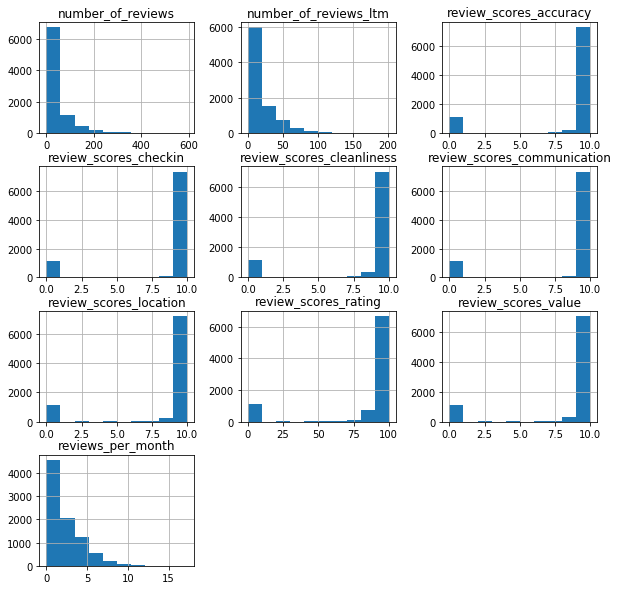

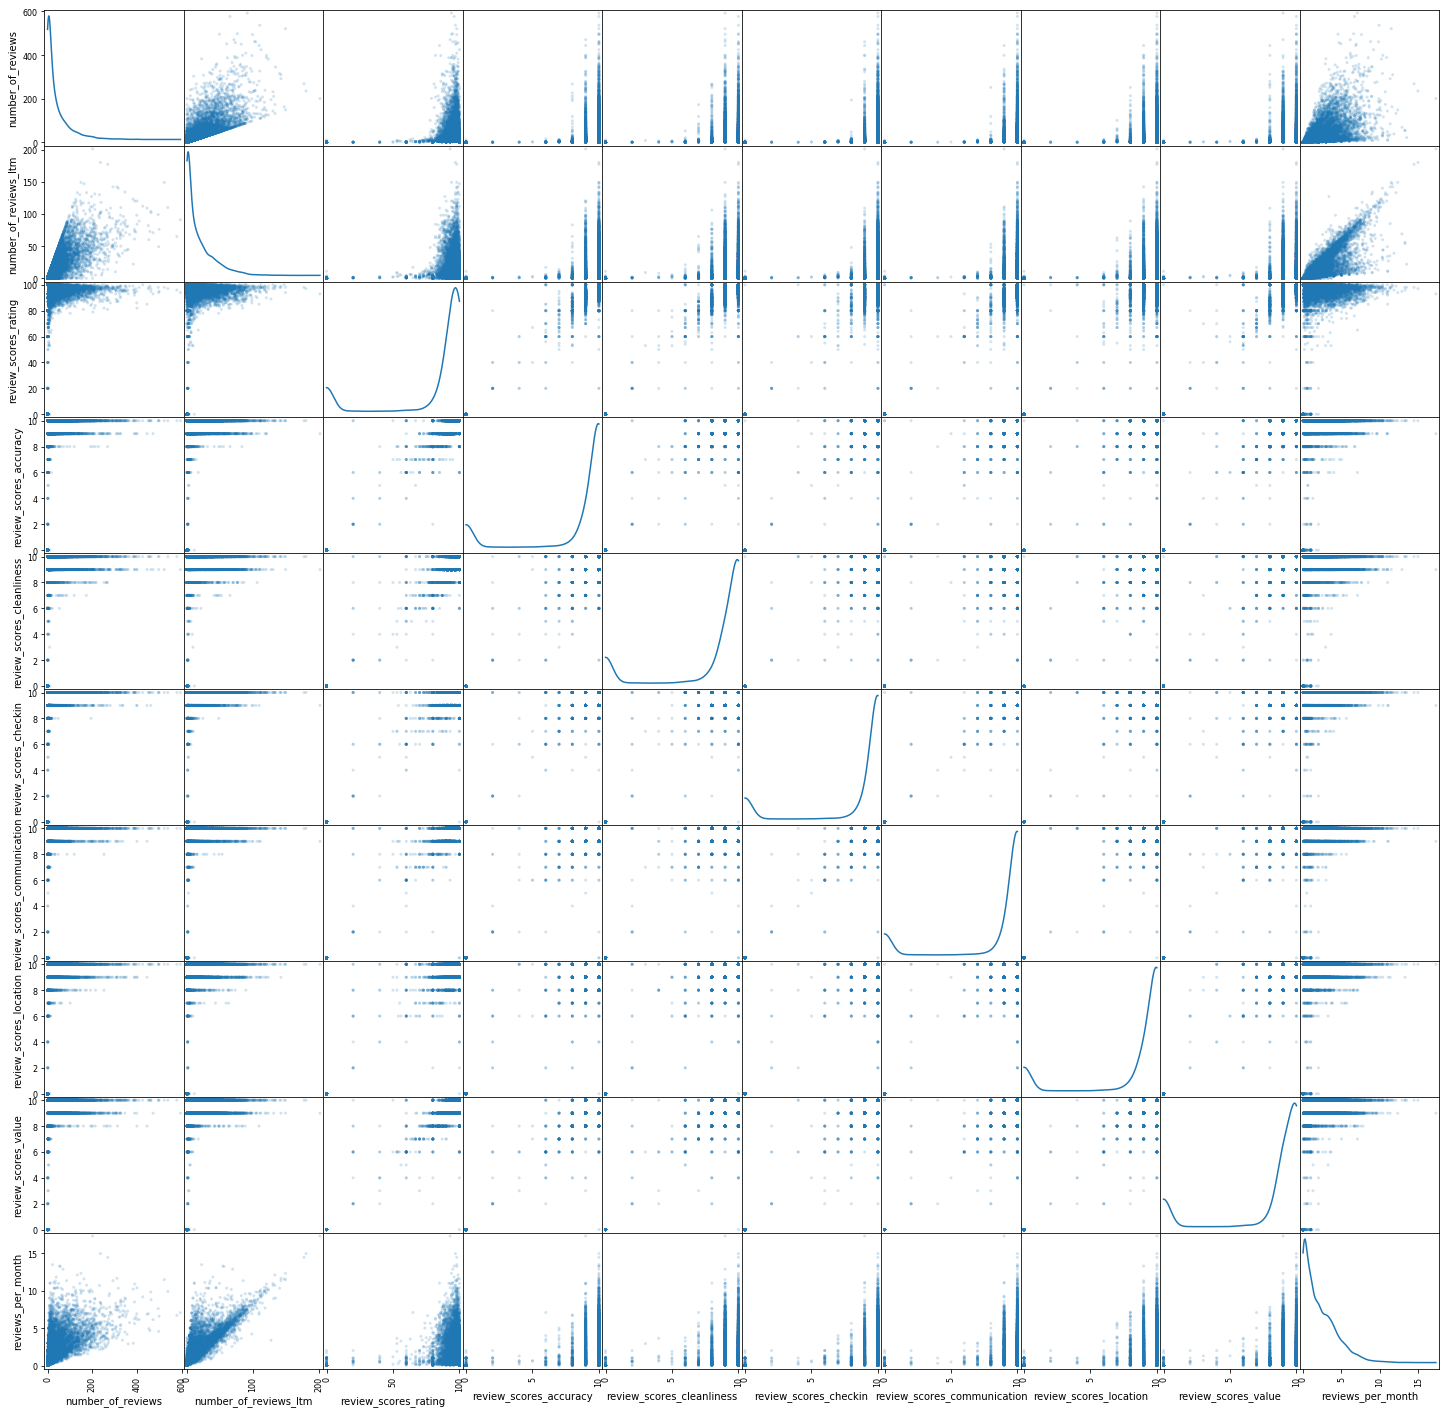

In [29]:
reviews_df = air_df[['number_of_reviews', 
                    'number_of_reviews_ltm', 
                    'review_scores_rating', 
                    'review_scores_accuracy', 
                    'review_scores_cleanliness', 
                    'review_scores_checkin', 
                    'review_scores_communication', 
                    'review_scores_location', 
                    'review_scores_value', 
                    'reviews_per_month'
                   ]]

reviews_df.hist(figsize=(10,10));
pd.plotting.scatter_matrix(reviews_df, alpha=0.2, figsize=(25, 25), diagonal='kde');

https://seaborn.pydata.org/generated/seaborn.heatmap.html<br/>
`
corr = np.corrcoef(np.random.randn(10, 200))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True)`

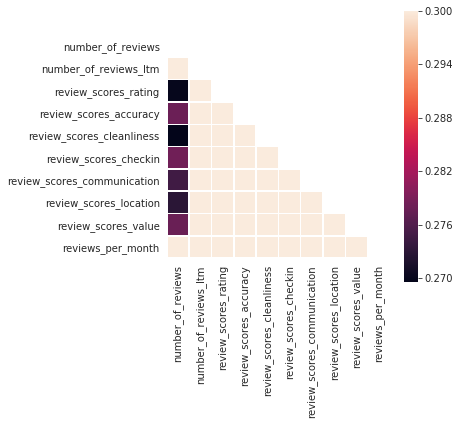

In [30]:
plt.figure(figsize=(5, 5))

corr = reviews_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, linewidths=.5)

In [31]:
# number_of_reviews
# review_scores_rating

temp = ['number_of_reviews_ltm', 
        'review_scores_accuracy', 
        'review_scores_cleanliness', 
        'review_scores_checkin', 
        'review_scores_communication', 
        'review_scores_location', 
        'review_scores_value', 
        'reviews_per_month'
       ]

air_df.drop(temp, axis=1, inplace=True)
del temp

air_df.head(2)

,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,instant_bookable
0,1,1,1,Hyde Park,41.78886,-87.58671,Condominium,Private room,1,1.0,1.0,1.0,"{TV,Wifi,Kitchen,Breakfast,""Free street parkin...",50.0,0.0,20.0,1,0.0,2,91,330,170,100.0,1
1,1,1,1,Little Village,41.85495,-87.69696,Apartment,Entire home/apt,7,1.0,3.0,4.0,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",117.0,0.0,35.0,2,25.0,2,60,348,383,96.0,1


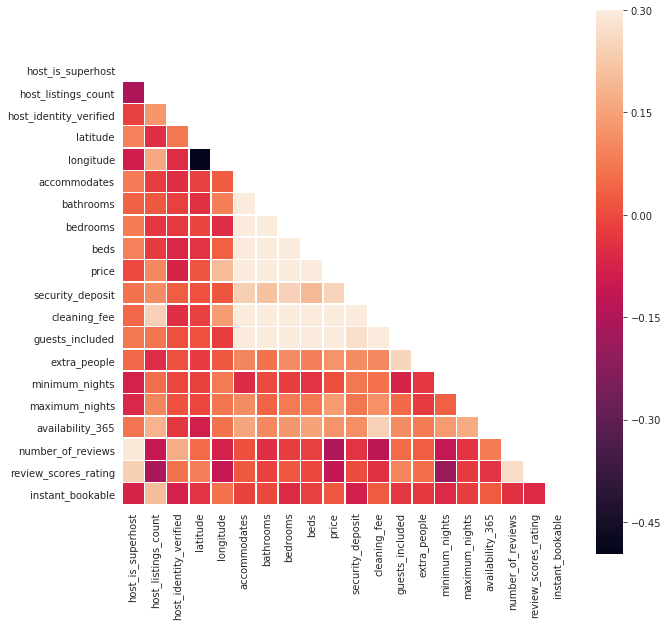

In [32]:
plt.figure(figsize=(10, 10))

corr = air_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, linewidths=.5)

# Reviewing Amenities (another day)

In [33]:
amenities_df = air_df['amenities'].copy

# :(

In [34]:
air_df.drop('amenities', axis=1, inplace=True)

In [35]:
air_df.head(2)

,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,instant_bookable
0,1,1,1,Hyde Park,41.78886,-87.58671,Condominium,Private room,1,1.0,1.0,1.0,50.0,0.0,20.0,1,0.0,2,91,330,170,100.0,1
1,1,1,1,Little Village,41.85495,-87.69696,Apartment,Entire home/apt,7,1.0,3.0,4.0,117.0,0.0,35.0,2,25.0,2,60,348,383,96.0,1


In [38]:
air_dum_df = pd.get_dummies(air_df)

air_dum_df.head(2)

,host_is_superhost,host_listings_count,host_identity_verified,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,instant_bookable,neighbourhood_Albany Park,neighbourhood_Andersonville,neighbourhood_Archer Heights,neighbourhood_Armour Square,neighbourhood_Ashburn,neighbourhood_Auburn Gresham,neighbourhood_Austin,neighbourhood_Avalon Park,neighbourhood_Avondale,neighbourhood_Back of the Yards,neighbourhood_Belmont Cragin,neighbourhood_Beverly,neighbourhood_Boystown,neighbourhood_Bridgeport,neighbourhood_Brighton Park,neighbourhood_Bronzeville,neighbourhood_Bucktown,neighbourhood_Calumet Heights,neighbourhood_Chatham,neighbourhood_Chinatown,neighbourhood_Clearing,neighbourhood_Dunning,neighbourhood_Edgewater,neighbourhood_Edison Park,neighbourhood_Englewood,neighbourhood_Gage Park,neighbourhood_Galewood,neighbourhood_Garfield Park,neighbourhood_Garfield Ridge,neighbourhood_Gold Coast,neighbourhood_Grand Crossing,neighbourhood_Hegewisch,neighbourhood_Hermosa,...,neighbourhood_Logan Square,neighbourhood_Loop,neighbourhood_Magnificent Mile,neighbourhood_Marquette Park,neighbourhood_McKinley Park,neighbourhood_Montclare,neighbourhood_Morgan Park,neighbourhood_Mt. Greenwood,neighbourhood_Near North Side,neighbourhood_Near West Side,neighbourhood_North Center,neighbourhood_North Lawndale,neighbourhood_North Park,neighbourhood_Norwood Park,neighbourhood_O'Hare,neighbourhood_Oakland,neighbourhood_Old Town,neighbourhood_Pilsen,neighbourhood_Portage Park,neighbourhood_Pullman,neighbourhood_River North,neighbourhood_River West,neighbourhood_Riverdale,neighbourhood_Rogers Park,neighbourhood_Roscoe Village,neighbourhood_Roseland,neighbourhood_Sauganash,neighbourhood_South Chicago,neighbourhood_South Deering,neighbourhood_South Loop/Printers Row,neighbourhood_South Shore,neighbourhood_Streeterville,neighbourhood_Ukrainian Village,neighbourhood_Uptown,neighbourhood_Washington Heights,neighbourhood_Washington Park,neighbourhood_West Elsdon,neighbourhood_West Lawn,neighbourhood_West Loop/Greektown,neighbourhood_West Pullman,neighbourhood_West Ridge,neighbourhood_West Town/Noble Square,neighbourhood_Wicker Park,neighbourhood_Woodlawn,neighbourhood_Wrigleyville,property_type_Apartment,property_type_Condominium,property_type_House,property_type_Other,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,1,1,1,41.78886,-87.58671,1,1.0,1.0,1.0,50.0,0.0,20.0,1,0.0,2,91,330,170,100.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,1,1,1,41.85495,-87.69696,7,1.0,3.0,4.0,117.0,0.0,35.0,2,25.0,2,60,348,383,96.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


# KNN

In [65]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# original

# air_dum_df = air_dum_df[['latitude',
#                          'longitude',
#                          'accommodates',
#                          'bathrooms',
#                          'bedrooms',
#                          'beds',
#                          'minimum_nights',
#                          'maximum_nights',
#                          'price'
#                         ]].copy()

In [66]:
X = air_dum_df.drop('price', axis=1)
y = air_dum_df.price

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [67]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

k: 1, Train/Test Score: 1.00/0.14
k: 3, Train/Test Score: 0.40/0.11
k: 5, Train/Test Score: 0.31/0.11
k: 7, Train/Test Score: 0.26/0.10
k: 9, Train/Test Score: 0.24/0.10
k: 11, Train/Test Score: 0.22/0.10
k: 13, Train/Test Score: 0.21/0.10
k: 15, Train/Test Score: 0.19/0.10
k: 17, Train/Test Score: 0.19/0.09
k: 19, Train/Test Score: 0.18/0.10
k: 21, Train/Test Score: 0.17/0.10
k: 23, Train/Test Score: 0.16/0.09
k: 25, Train/Test Score: 0.16/0.09
k: 27, Train/Test Score: 0.15/0.09
k: 29, Train/Test Score: 0.15/0.09
k: 31, Train/Test Score: 0.14/0.08
k: 33, Train/Test Score: 0.14/0.08
k: 35, Train/Test Score: 0.14/0.08
k: 37, Train/Test Score: 0.14/0.08
k: 39, Train/Test Score: 0.14/0.08
k: 41, Train/Test Score: 0.13/0.08
k: 43, Train/Test Score: 0.13/0.08
k: 45, Train/Test Score: 0.13/0.08
k: 47, Train/Test Score: 0.12/0.08
k: 49, Train/Test Score: 0.12/0.08


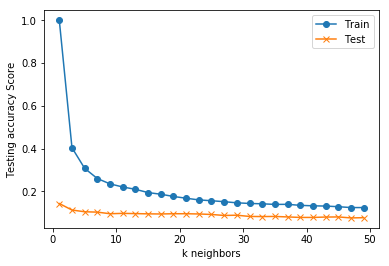

In [68]:
train_scores = []
test_scores = []

for k in range(1, 50, 2):
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski')
    knn.fit(X_train, y_train)
    train_score = knn.score(X_train, y_train)
    test_score = knn.score(X_test, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.2f}/{test_score:.2f}")
    
plt.plot(range(1, 50, 2), train_scores, marker='o', label='Train')
plt.plot(range(1, 50, 2), test_scores, marker="x", label='Test')
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.legend()
plt.show()

k: 1, Train/Test Score: 1.00/0.14
k: 3, Train/Test Score: 0.40/0.11
k: 5, Train/Test Score: 0.31/0.11
k: 7, Train/Test Score: 0.26/0.10
k: 9, Train/Test Score: 0.24/0.10
k: 11, Train/Test Score: 0.22/0.10
k: 13, Train/Test Score: 0.21/0.10
k: 15, Train/Test Score: 0.19/0.10
k: 17, Train/Test Score: 0.19/0.09
k: 19, Train/Test Score: 0.18/0.10
k: 21, Train/Test Score: 0.17/0.10
k: 23, Train/Test Score: 0.16/0.09
k: 25, Train/Test Score: 0.16/0.09
k: 27, Train/Test Score: 0.15/0.09
k: 29, Train/Test Score: 0.15/0.09
k: 31, Train/Test Score: 0.14/0.08
k: 33, Train/Test Score: 0.14/0.08
k: 35, Train/Test Score: 0.14/0.08
k: 37, Train/Test Score: 0.14/0.08
k: 39, Train/Test Score: 0.14/0.08
k: 41, Train/Test Score: 0.13/0.08
k: 43, Train/Test Score: 0.13/0.08
k: 45, Train/Test Score: 0.13/0.08
k: 47, Train/Test Score: 0.12/0.08
k: 49, Train/Test Score: 0.12/0.08


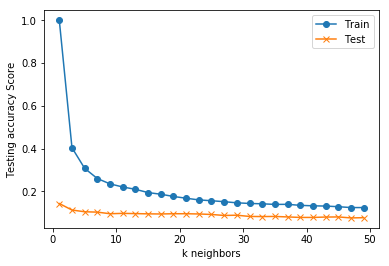

In [71]:
train_scores = []
test_scores = []

for k in range(1, 50, 2):
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(X_train, y_train)
    train_score = knn.score(X_train, y_train)
    test_score = knn.score(X_test, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.2f}/{test_score:.2f}")
    
plt.plot(range(1, 50, 2), train_scores, marker='o', label='Train')
plt.plot(range(1, 50, 2), test_scores, marker="x", label='Test')
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.legend()
plt.show()

In [72]:
y_pred = classifier.predict(X_test)
y_pred

array([110.,  49., 199., ...,  75.,  26., 150.])

In [73]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(f1_score(y_test, y_pred , average='micro'))

[[16  0  0 ...  0  0  0]
 [ 0  1  1 ...  0  0  0]
 [ 0  0  1 ...  0  0  0]
 ...
 [ 0  0  0 ...  3  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
0.19493962047153537


In [74]:
print(accuracy_score(y_test, y_pred))

0.19493962047153537


In [ ]:
# KNN Regressor

# from sklearn.metrics import mean_squared_error
# from sklearn.neighbors import KNeighborsRegressor

# train_df = temp.iloc[0:2213]
# test_df = temp.iloc[2213:]

# train_columns = ['accommodates']

# knn = KNeighborsRegressor(n_neighbors=93, algorithm='auto')
# # knn = KNeighborsRegressor(n_neighbors=5, algorithm='brute')

# features = train_df.columns.tolist()
# features.remove('price')
# knn.fit(train_df[features], train_df['price'])

# all_features_predictions = knn.predict(test_df[features])
# all_features_mse = mean_squared_error(test_df['price'], all_features_predictions)
# all_features_rmse = all_features_mse ** (1/2)

# print(f'MSE: ${all_features_mse:,.2f}')
# print(f'RMSE: ${all_features_rmse:,.2f}')

# XGBoost 
https://www.kaggle.com/mgabrielkerr/visualizing-knn-svm-and-xgboost-on-iris-dataset<br/><br/>
https://xgboost.readthedocs.io/en/latest/python/python_api.html<br/>
https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e<br/>
https://www.kaggle.com/kobakhit/xgboost<br/>
https://www.kaggle.com/gayathrydasika/xgb-regressor-basic<br/>
https://www.datacamp.com/community/tutorials/xgboost-in-python<br/>
https://heartbeat.fritz.ai/boosting-your-machine-learning-models-using-xgboost-d2cabb3e948f<br/>
https://towardsdatascience.com/modeling-price-with-regularized-linear-model-xgboost-55e59eae4482<br/>
https://www.youtube.com/watch?v=yjZbTTdYmk0

In [75]:
import xgboost as xgb
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score

X = air_dum_df.drop('price', axis=1)
y = air_dum_df.price

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [77]:
print(f'Train Shape: {X_train.shape[0]:,}\nTest Shape: {X_test.shape[0]:,}')

Train Shape: 6,953
Test Shape: 1,739


In [79]:
xgb_clf = xgb.XGBRegressor(n_estimators=1000,max_depth=3,learning_rate=.1,colsample_bytree=.8)
xgb_clf.fit(X_train, y_train)
xgb_preds = xgb_clf.predict(X_train)
xgb_tests = xgb_clf.predict(X_test)

print(f'\nTrain MSE: {mean_squared_error(y_train, xgb_preds):,.2f}')
print(f'Test MSE: {mean_squared_error(y_test, xgb_tests):,.2f}')

print(f'\nTrain Accuracy/R2: {xgb_clf.score(X_train, y_train):.1%}')
print(f'Test Accuracy/R2: {xgb_clf.score(X_test, y_test):.1%}')

[15:11:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Train MSE: 1,878.53
Test MSE: 4,224.33

Train Accuracy/R2: 86.4%
Test Accuracy/R2: 70.2%


OrderedDict([('latitude', 684),
             ('longitude', 643),
             ('cleaning_fee', 515),
             ('host_listings_count', 510),
             ('availability_365', 426),
             ('accommodates', 395),
             ('number_of_reviews', 297),
             ('security_deposit', 282),
             ('maximum_nights', 238),
             ('extra_people', 231),
             ('beds', 202),
             ('bedrooms', 196),
             ('bathrooms', 189),
             ('minimum_nights', 189),
             ('guests_included', 172),
             ('review_scores_rating', 119),
             ('host_is_superhost', 80),
             ('room_type_Hotel room', 76),
             ('neighbourhood_Lakeview', 63),
             ('host_identity_verified', 52),
             ('neighbourhood_River North', 49),
             ('neighbourhood_Wrigleyville', 49),
             ('neighbourhood_South Loop/Printers Row', 44),
             ('neighbourhood_Archer Heights', 44),
             ('neighbourhood_P

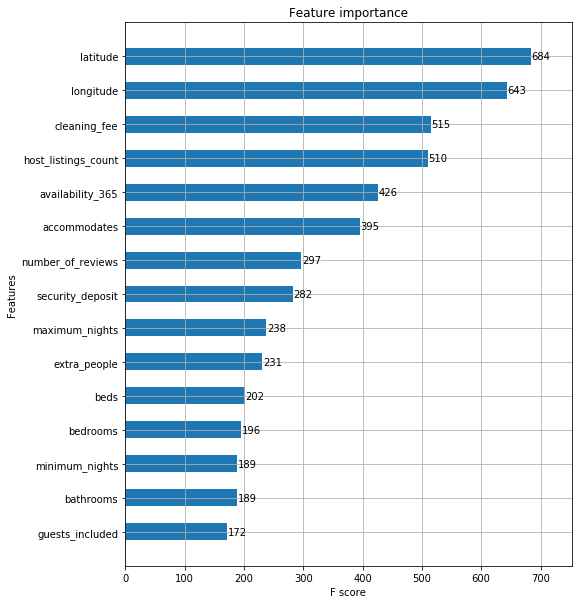

In [80]:
from collections import OrderedDict
# xgb_clf.get_booster().get_score(importance_type='weight')

fig, ax = plt.subplots(figsize = (8, 10))
xgb.plot_importance(xgb_clf, max_num_features = 15, height = .5, ax = ax);

OrderedDict(sorted(xgb_clf.get_booster().get_fscore().items(), key=lambda x: x[1], reverse=True))

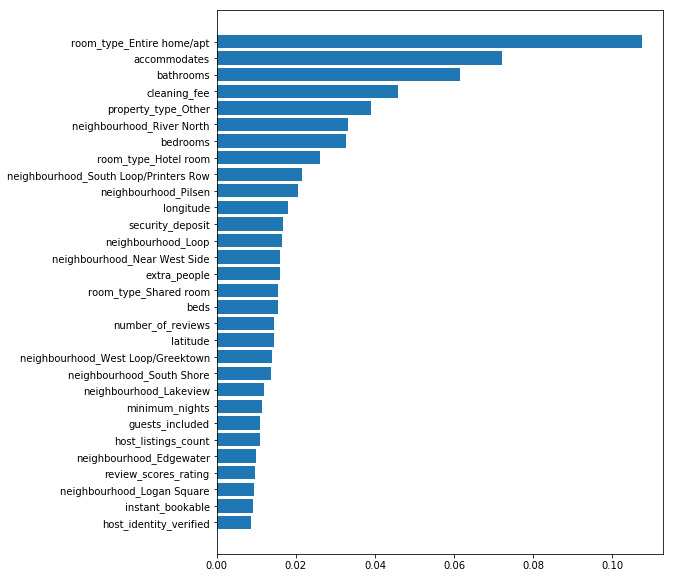

In [81]:
temp = pd.DataFrame(xgb_clf.feature_importances_, columns=['weight'], index = X_train.columns)
temp.sort_values('weight', inplace=True)

# plotting top 30
temp = temp.iloc[84:-1]

plt.figure(figsize=(8,10))
plt.barh(temp.index, temp.weight)

del temp
plt.show()